# Exercise Session: Logistic Regression
$\renewcommand{\real}{\mathbb{R}}$
$\renewcommand{\xb}{\mathbf{x}}$
$\renewcommand{\wb}{\mathbf{w}}$
$\renewcommand{\Xb}{\mathbf{X}}$
$\renewcommand{\yb}{\mathbf{y}}$
$\renewcommand{\Yb}{\mathbf{Y}}$
$\DeclareMathOperator*{\argmin}{argmin}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# project files
import sys
sys.path.append('..')
import helpers as helpers

# 3rd party
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# 1 Introduction

This week's exercise is about linear classification, in particular, logistic regression. We will focus on the binary classification scenario, i.e., two classes.

# 2 Binary Classification with Logistic Regression

Let's start by loading the [_Iris Flower Dataset_](https://en.wikipedia.org/wiki/Iris_flower_data_set). To facilitate visualization, we will only use 2 out of the 4 features of this dataset. Furthermore, we will use 2 out of the 3 classes in this dataset, named *setosa* and *versicolor*. Therefore, for this part our dataset with two classes is as follows:

  - data: $\Xb \in \real^{N \times 3}$, $\forall \xb_i \in \Xb: \xb_i \in \real^{3}$ (2 features and the bias)
  - labels: $\yb \in \real^{N}$, $\forall y_i \in \yb: y_i \in \{0, 1\}$ 

Note that $\Xb$ is a matrix of shape $(N \times (D+1))$. However, a single data sample $\xb_i$ is a column vector of shape $((D+1) \times 1)$. 
To compute a scalar product of one data sample with the weight vector $\wb$ (also a column vector of shape $((D+1) \times 1)$), we write $\xb_i^\top\cdot\wb$. To perform a matrix-vector multiplication of the entire data matrix with the weight vector, we write $\Xb\cdot\wb$.

<IPython.core.display.Javascript object>


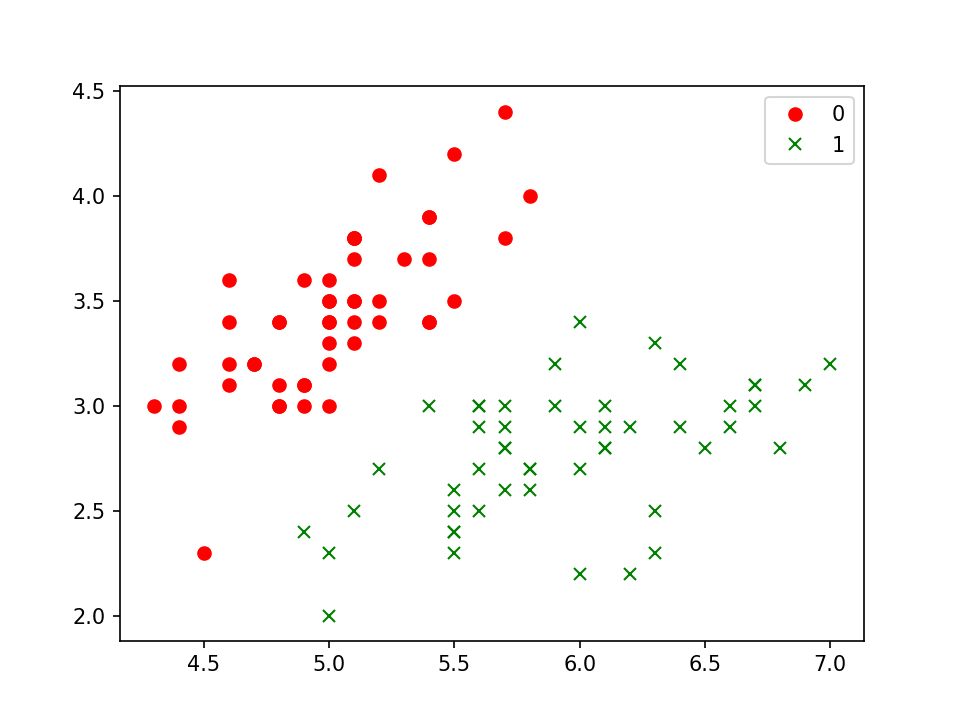

In [3]:
# Loads the data and split them into training and test subsets.
data, labels = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False,
                              setosa=True, versicolor=True, virginica=False, addbias=True)
fig = helpers.scatter2d_multiclass(data, labels)

num_samples = data.shape[0]

fraction_train = 0.8
np.random.seed(0)
rinds = np.random.permutation(num_samples)

data_train = data[rinds[:int(num_samples * fraction_train)]] 
labels_train = labels[rinds[:int(num_samples * fraction_train)]]  

data_test = data[rinds[int(num_samples * fraction_train):]] 
labels_test = labels[rinds[int(num_samples * fraction_train):]]  

## 2.1 Short introduction

In logistic regression, the probability (score) that a data point belongs to the positive class is expressed as
$$P(y_i=1|\xb_i, \wb) = \frac{1}{1+e^{-\xb_i^{\top}\cdot \wb}} $$

This relies on the sigmoid function is defined as
$$\sigma(t)= \frac{1}{1+e^{-t}}$$

So in our case, the prediction of our model is defined as
$$\hat{y}(\xb_i)=\sigma(\xb_i^{\top}\cdot \wb)= \frac{1}{1+e^{-\xb_i^{\top}\cdot \wb}}$$

Let us code this function. You can use the numpy function `np.exp(x)` to take the exponential of a number.

In [7]:
def sigmoid(t):
    """ Sigmoid function
    
    Args:
        t (np.array): Input data of shape (N, )
        
    Returns:
        np.array: Probabilites of shape (N, ), where each value is in [0, 1].
    """
    return 1/(1+np.exp(-t))

Recall that the cross entropy loss is defined as:
$$
R(\wb) = -\sum_i (y_i \log(\hat{y}(\xb_i)) + (1-y_i)\log(1-\hat{y}(\xb_i))) $$

Let's code it using NumPy. If you do it correctly, it can be written in one line!

In [16]:
def loss_logistic(data, labels, w): 
    """ Logistic regression loss function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        int: Loss of logistic regression.
    """
    predictions = sigmoid(data @ w)
    log_pos = np.log(predictions)
    log_neg = np.log(1-predictions)
    return np.sum( labels @ log_pos + (1-labels) @ log_neg )

In [56]:
loss_logistic(
    np.random.random(10*3).reshape(10,3),
    np.random.random(10),
    np.random.random(3)
)

-6.25699405147725

To move the weight vector towards the optimal weights, we need to compute the gradient of the loss function. This gradient is defined as
$$\nabla R(\wb)= \sum_i (\hat{y}(\xb_i) - y_i)\xb_i $$
Let us put this into a nice matrix format:
$$\nabla R(\wb)= \Xb^\top(\hat{y}(\Xb) - \yb) = \Xb^\top(\sigma(\Xb\cdot \wb) - \yb),
$$

where $\hat{y}(\Xb) = \sigma(\Xb\cdot \wb)$ and $\sigma(\Xb\cdot \wb)$ computes the sigmoid for each data sample separately, and returns a vector of shape $(N \times 1)$.

Fill in the function for computing the gradient `gradient_logistic()`. You can use the numpy function `np.dot()` or an operator `@` for matrix multiplication.

In [71]:
def gradient_logistic(data, labels, w):
    """ Logistic regression gradient function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        np. array: Gradient array of shape (D, )
    """
    predictions = sigmoid(data @ w)
    return data.T @ (predictions - labels)

In [72]:
gradient_logistic(
    np.random.random((10,3)),
    np.random.random(10),
    np.random.random(3)
)

array([1.8006784 , 1.79679115, 1.94330741])

## 2.2 Classification using a logistic regression model

Now let us write a function to perform classification using logistic regression, `logistic_regression_classify()`. This function uses the weights we find during training to predict the labels for the data.

**Hints:**
* We classify our data according to $P(y_i=1|\xb_i, \wb)$. If the value of $P(y_i=1|\xb_i, \wb)$ is less than 0.5 then the data point is classified as label 0. If it is more than or equal to 0.5 then we classify the data point as label 1.

In [62]:
def logistic_regression_classify(data, w):
    """ Classification function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        np.array: Label assignments of data of shape (N, )
    """
    #### write your code here: find predictions and threshold.
    predictions = sigmoid(data @ w)
    predictions[predictions >= 0.5] = 1
    predictions[predictions < 0.5] = 0
     
    return predictions

We measure the performance of our classifier with *accuracy* metric. It is defined as $$ f_{\text{acc}} = \frac{\text{# correct predictions}}{\text{# all predictions}}$$
Implement the following `accuracy()` function using the predicted and ground truth labels.

In [67]:
def accuracy(labels_gt, labels_pred):
    """ Computes accuracy.
    
    Args:
        labels_gt (np.array): GT labels of shape (N, ).
        labels_pred (np.array): Predicted labels of shape (N, ).
        
    Returns:
        float: Accuracy, in range [0, 1].
    """
    
    
    return np.sum(labels_pred == labels_gt)/len(labels_gt)

## 2.3 Training a logistic regression model

To find the optimal weights for the given training data, we need to train our model. Fill in the missing parts of the function `logistic_regression_train()`.

The function first initializes the weights randomly (according to a Gaussian distribution). In each iteration, you should compute the gradient using `gradient_logistic` and take a gradient step to update the weights. Given that $\eta$ is the learning rate, recall that a gradient step is expressed as: $$ \wb_{[t + 1]}  = \wb_{[t]} - \eta \nabla R(\wb_{[t]}) $$

The `loss`, `plot` and `print_every` parameters affect the way the loss is printed and the predictions are displayed. You do not need to modify these parts.



In [68]:
def logistic_regression_train(data, labels, max_iters=10, lr=0.001, 
                              print_period=1000, plot_period=1000):
    """ Training function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        max_iters (integer): Maximum number of iterations. Default:10
        lr (integer): The learning rate of  the gradient step. Default:0.001
        print_period (int): Num. iterations to print current loss. 
            If 0, never printed.
        plot_period (int): Num. iterations to plot current predictions.
            If 0, never plotted.
    Returns:
        np.array: weights of shape(D, )
    """

    #initialize the weights randomly according to a Gaussian distribution
    weights = np.random.normal(0., 0.1, [data.shape[1],])
    for it in range(max_iters):
        ########## write your code here: find gradient and do a gradient step
        gradient = gradient_logistic(data,labels,weights)
        weights -= lr * gradient
        ##################################
        predictions = logistic_regression_classify(data, weights)
        if print_period and it % print_period == 0:
            print('loss at iteration', it, ":", loss_logistic(data, labels, weights))
        if plot_period and it % plot_period == 0:
            fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions)
            plt.title("iteration "+ str(it))
        if accuracy(labels, predictions) == 1:
            break
    fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions)
    plt.title("iteration "+ str(it))
    return weights

Run the code below to see your training in action. What do you observe? Try playing with the learning rate and number of max iterations.

loss at iteration 0 : -54.56640672774374


<IPython.core.display.Javascript object>


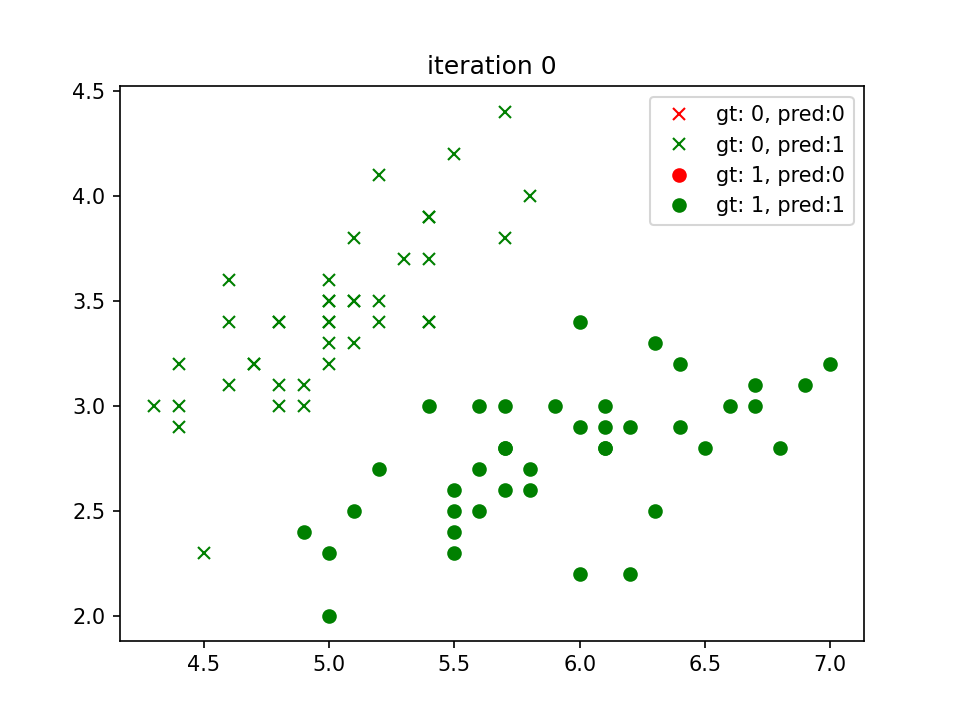

loss at iteration 1000 : -8.739492470766505
loss at iteration 2000 : -6.425868884430384
loss at iteration 3000 : -5.566026202909349


<IPython.core.display.Javascript object>


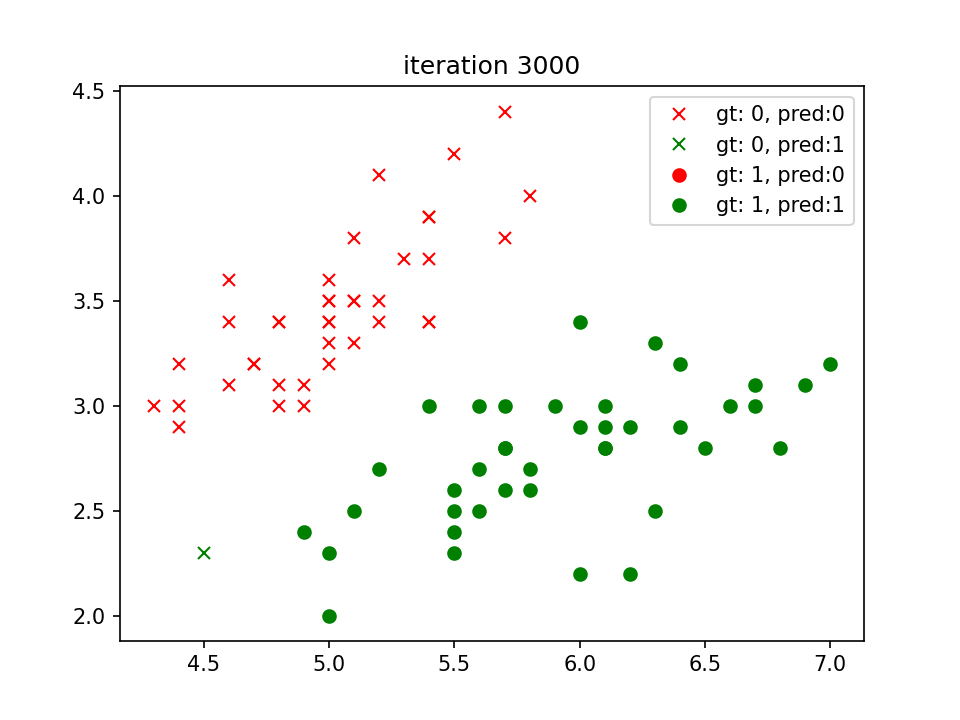

loss at iteration 4000 : -5.10462363703273
loss at iteration 5000 : -4.809562165750007
loss at iteration 6000 : -4.5996742192831


<IPython.core.display.Javascript object>


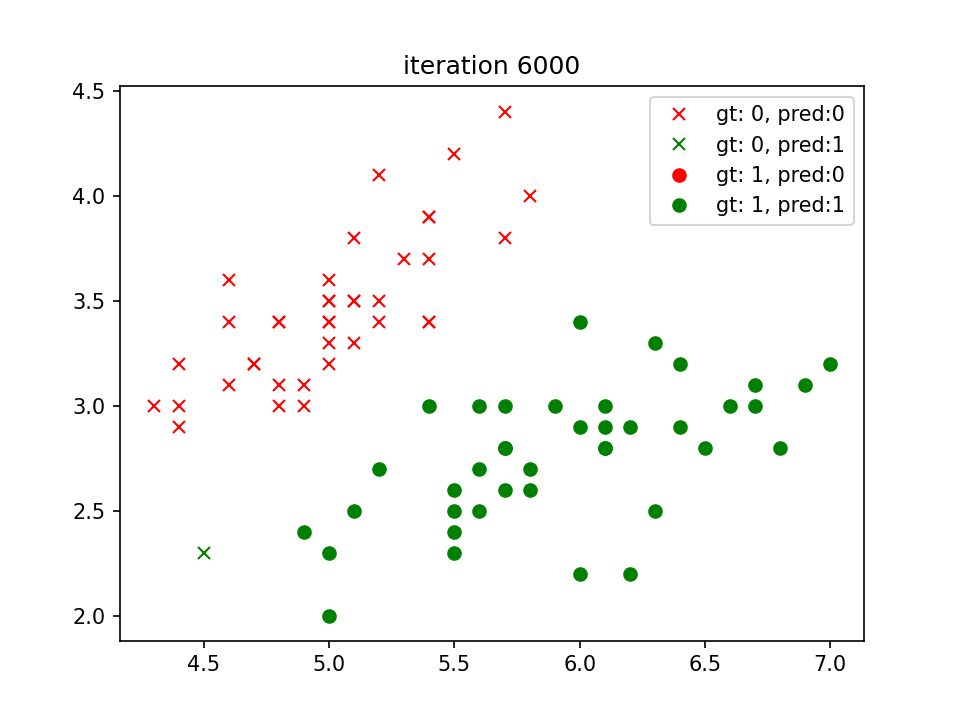

loss at iteration 7000 : -4.439136719895358
loss at iteration 8000 : -4.309698385852532
loss at iteration 9000 : -4.201100141540317


<IPython.core.display.Javascript object>


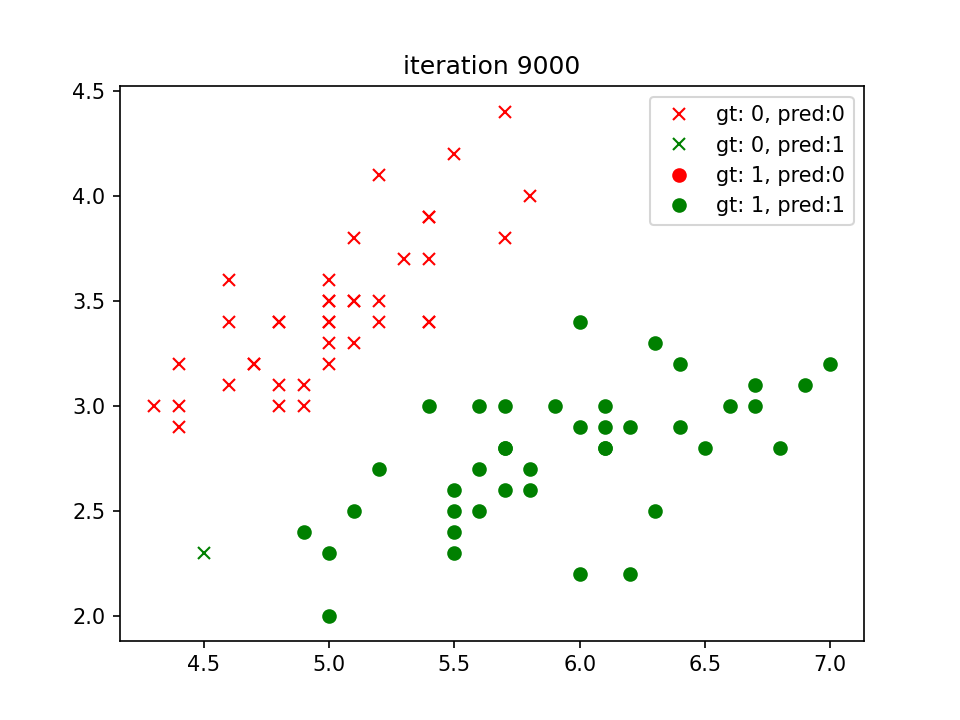

loss at iteration 10000 : -4.107146189407194
loss at iteration 11000 : -4.023883808339985
loss at iteration 12000 : -3.9486797362803103


<IPython.core.display.Javascript object>


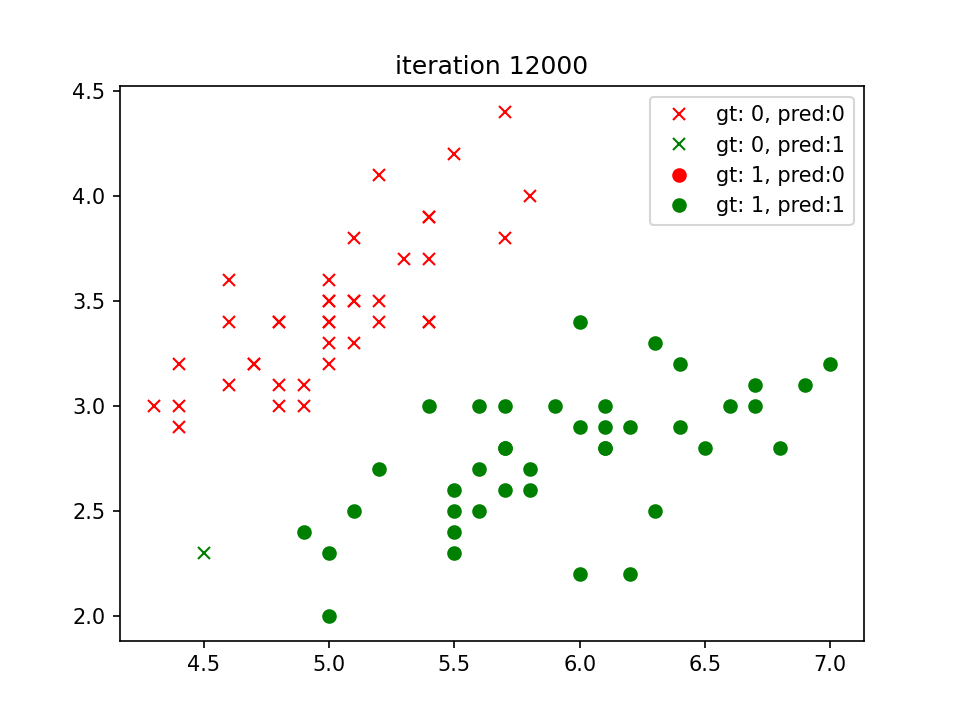

loss at iteration 13000 : -3.879717103701684
loss at iteration 14000 : -3.815705411605365
loss at iteration 15000 : -3.755705348911265


<IPython.core.display.Javascript object>


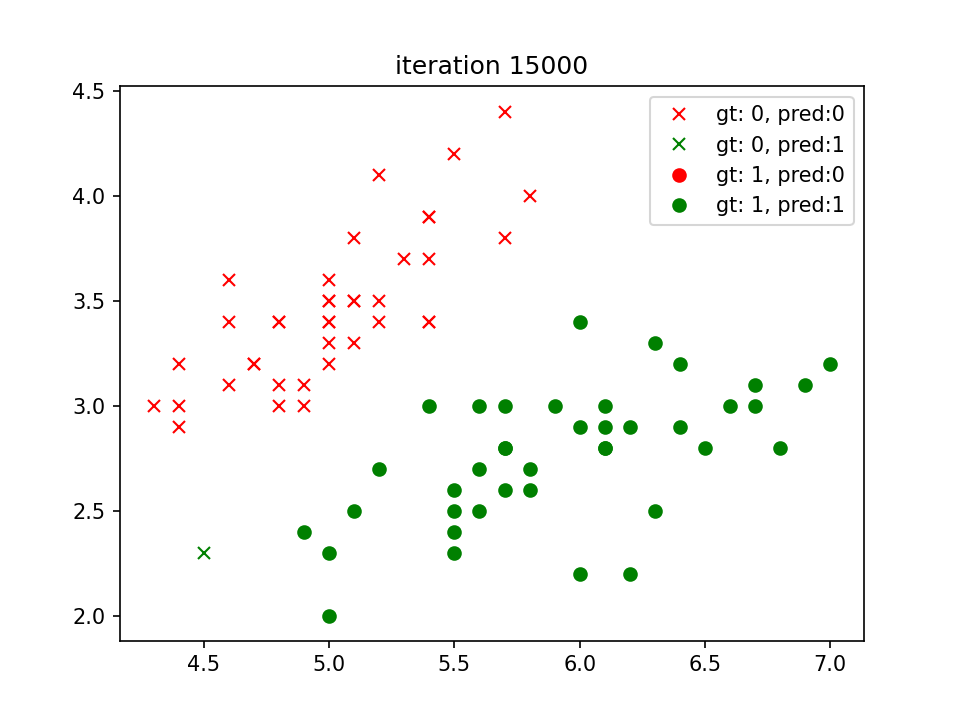

loss at iteration 16000 : -3.699018767932963
loss at iteration 17000 : -3.6451172563727856
loss at iteration 18000 : -3.5935944272885587


<IPython.core.display.Javascript object>


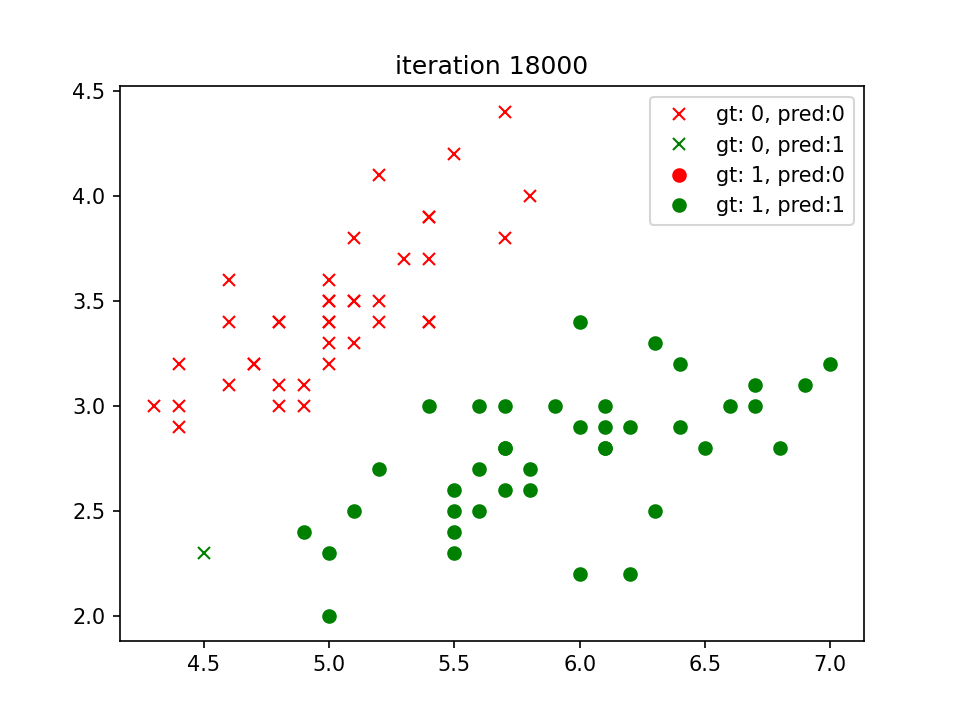

loss at iteration 19000 : -3.544133253566777
loss at iteration 20000 : -3.4964832129609915
loss at iteration 21000 : -3.450443988384013


<IPython.core.display.Javascript object>


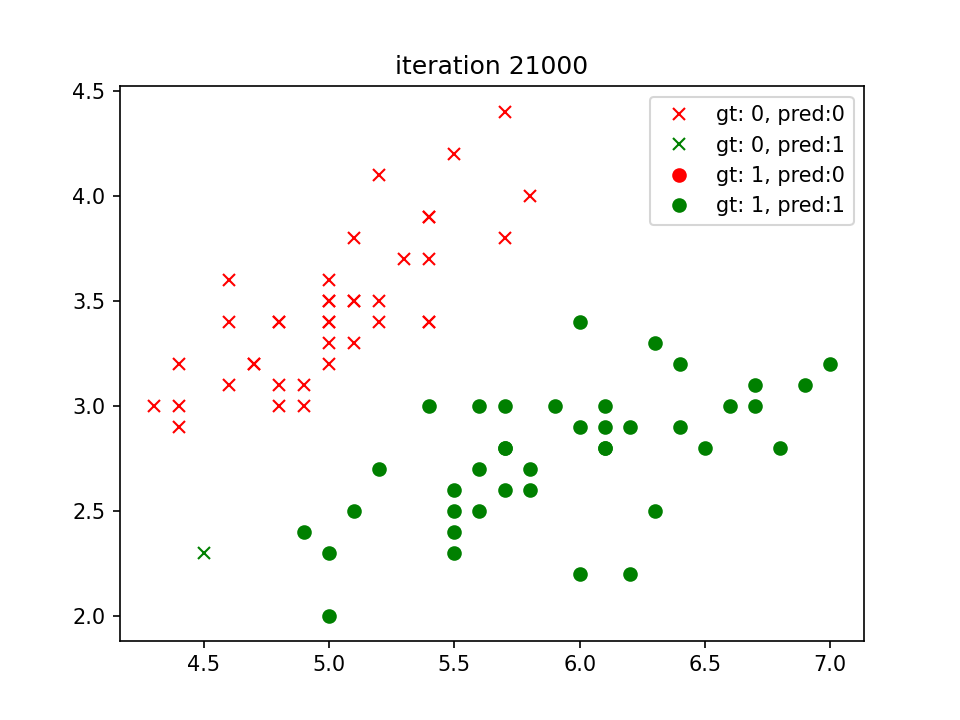

loss at iteration 22000 : -3.4058536440293006
loss at iteration 23000 : -3.3625799171287607
loss at iteration 24000 : -3.320513716505202


<IPython.core.display.Javascript object>


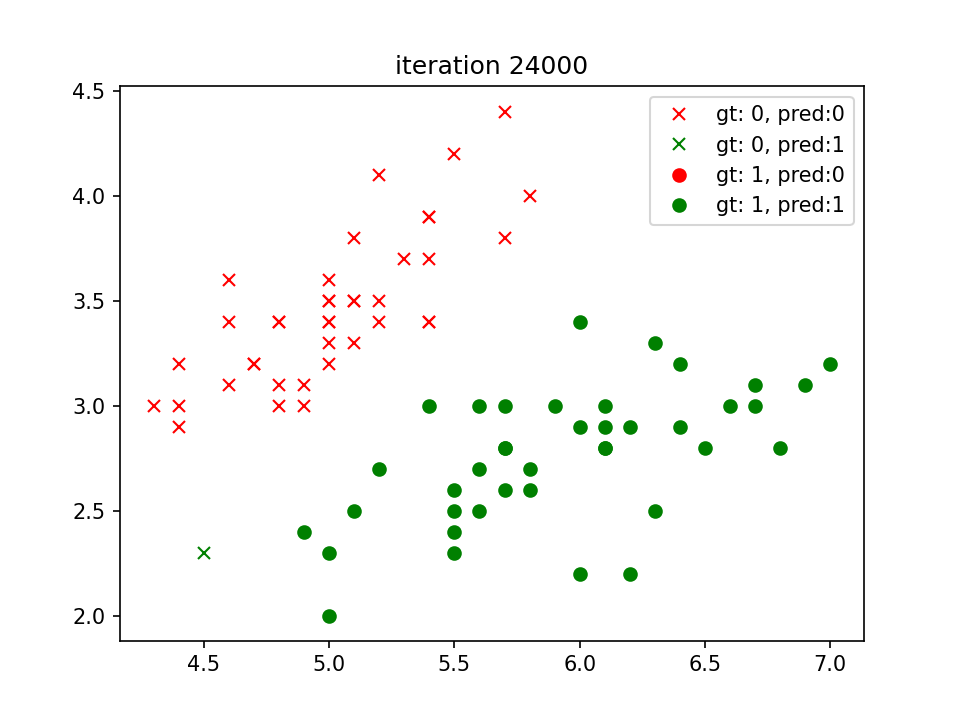

loss at iteration 25000 : -3.2795642089154144
loss at iteration 26000 : -3.2396550642059836
loss at iteration 27000 : -3.200721557259296


<IPython.core.display.Javascript object>


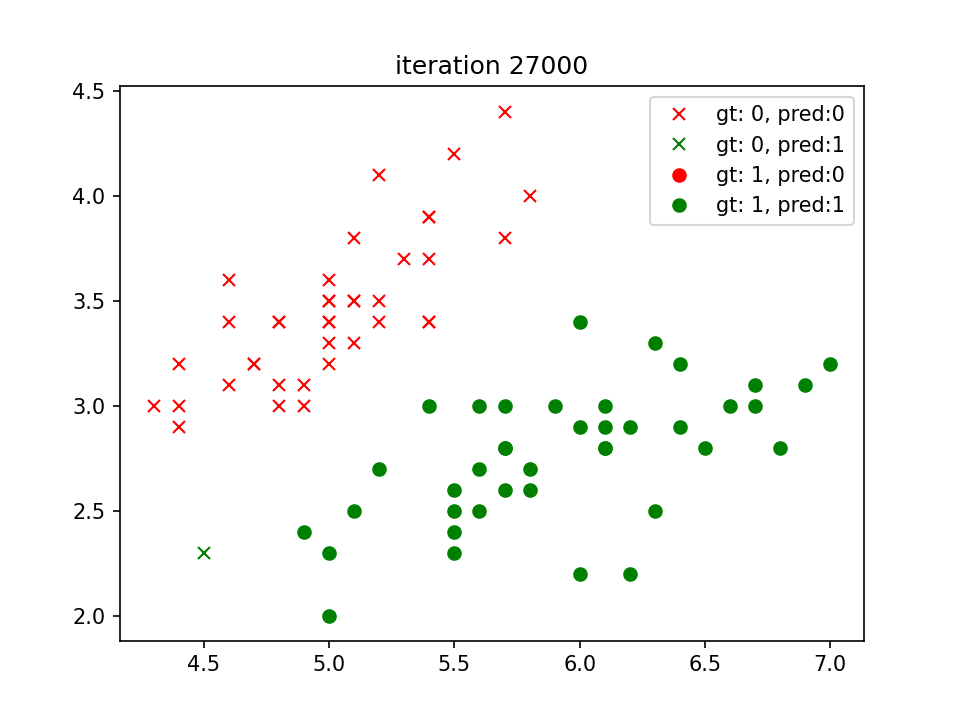

loss at iteration 28000 : -3.162708310993839
loss at iteration 29000 : -3.1255675242576038
loss at iteration 30000 : -3.0892575701830576


<IPython.core.display.Javascript object>


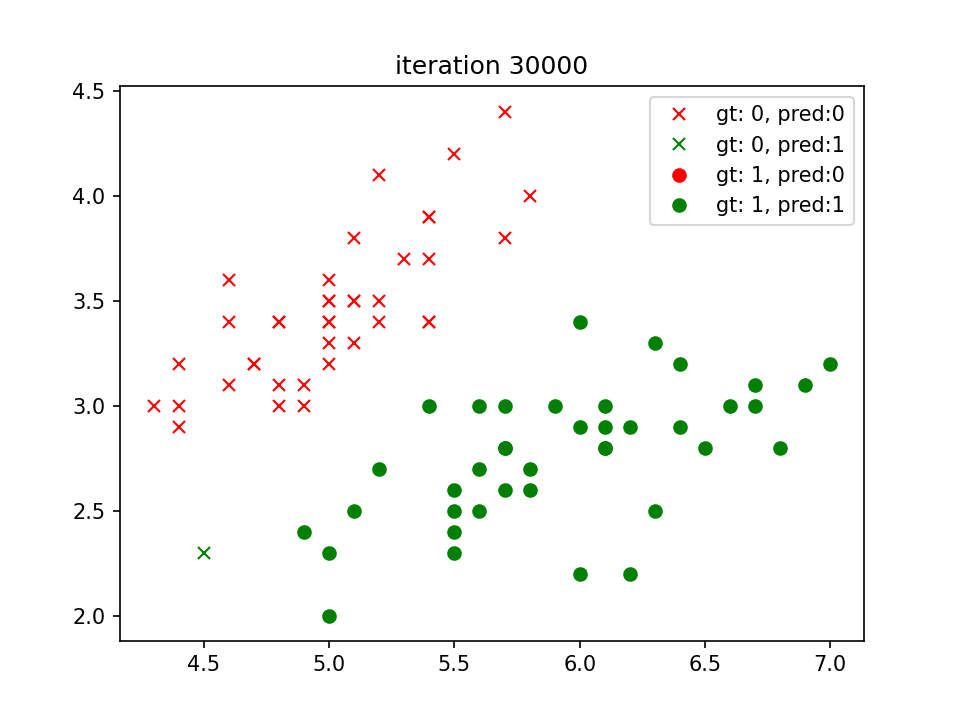

loss at iteration 31000 : -3.0537418801949907
loss at iteration 32000 : -3.01898805015164
loss at iteration 33000 : -2.9849671205757113


<IPython.core.display.Javascript object>


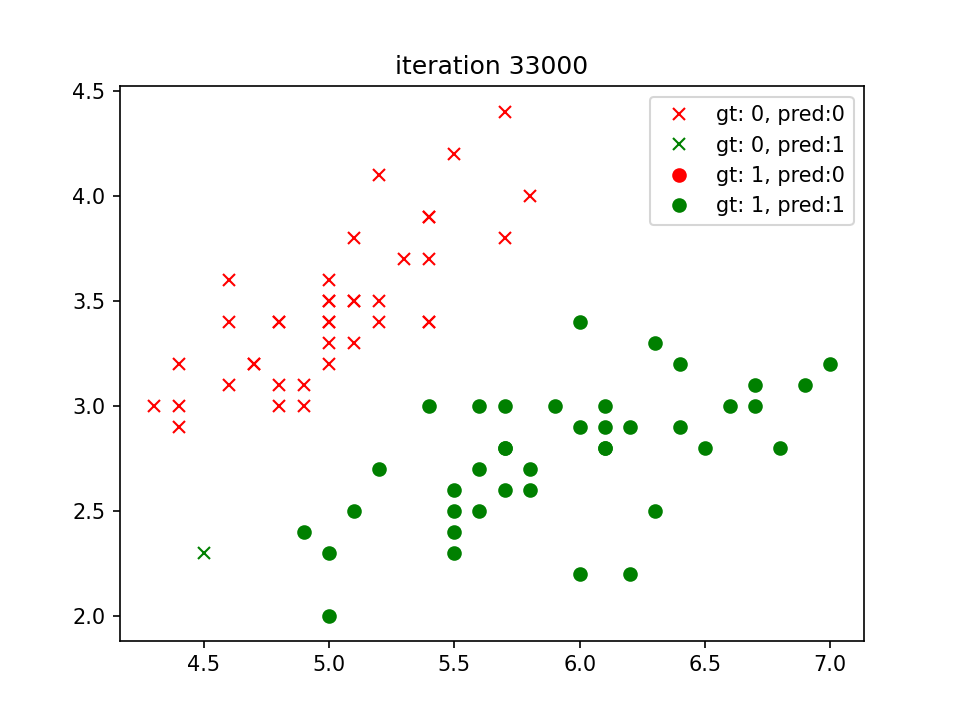

loss at iteration 34000 : -2.951652994303953
loss at iteration 35000 : -2.919021963323547
loss at iteration 36000 : -2.887052322886312


<IPython.core.display.Javascript object>


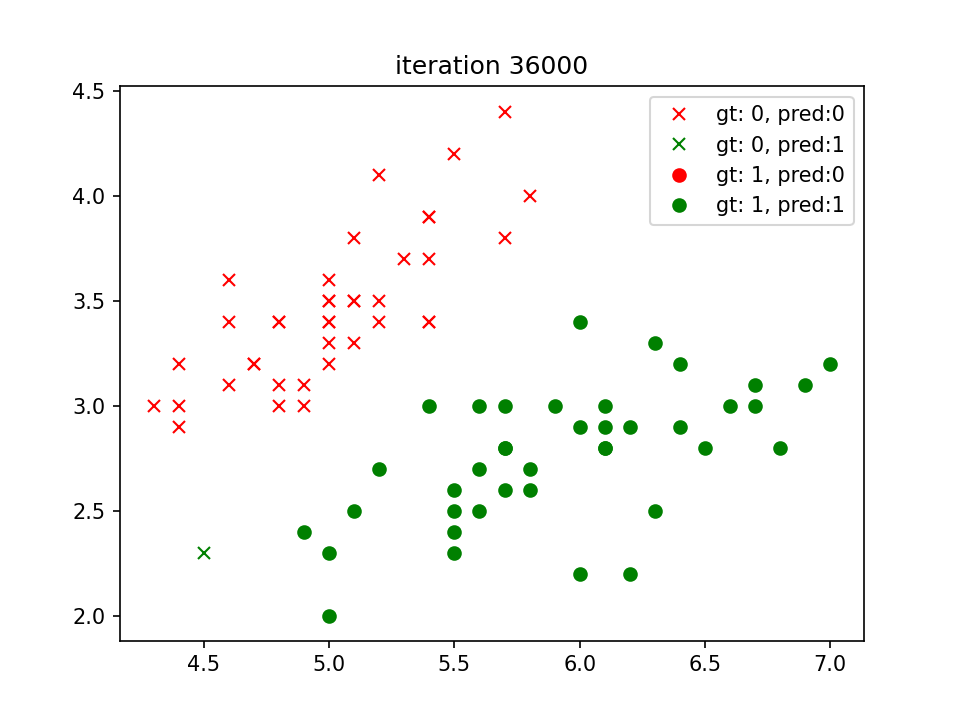

loss at iteration 37000 : -2.855724055770837
loss at iteration 38000 : -2.8250185732045496
loss at iteration 39000 : -2.79491850175597


<IPython.core.display.Javascript object>


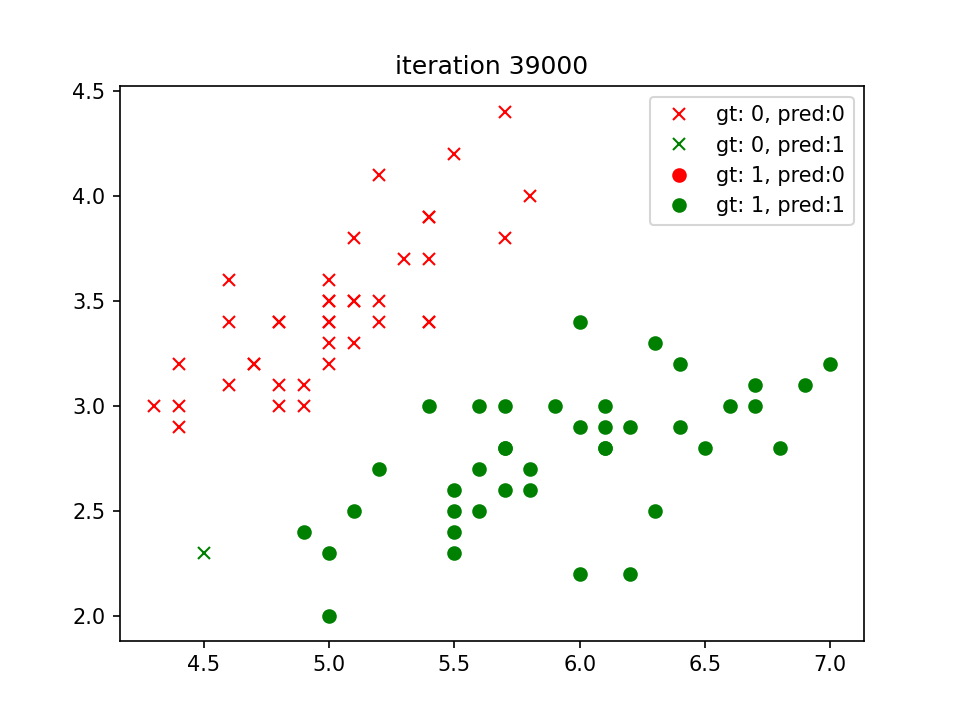

loss at iteration 40000 : -2.765407507672615
loss at iteration 41000 : -2.73647015182809
loss at iteration 42000 : -2.7080917697666376


<IPython.core.display.Javascript object>


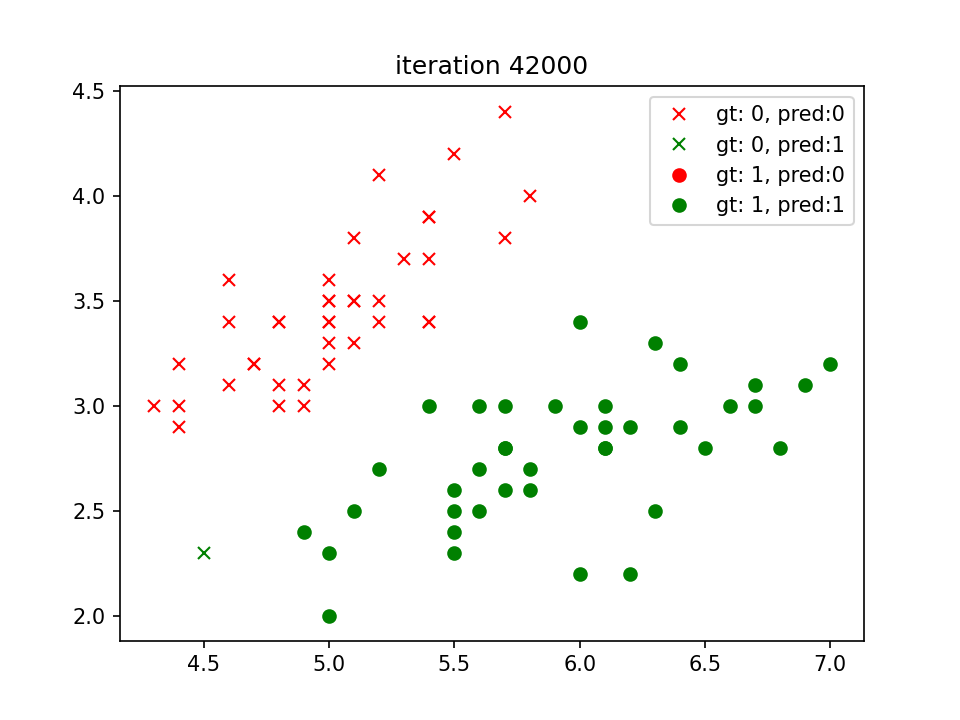

loss at iteration 43000 : -2.680258372379414
loss at iteration 44000 : -2.652956563578524
loss at iteration 45000 : -2.6261734719991985


<IPython.core.display.Javascript object>


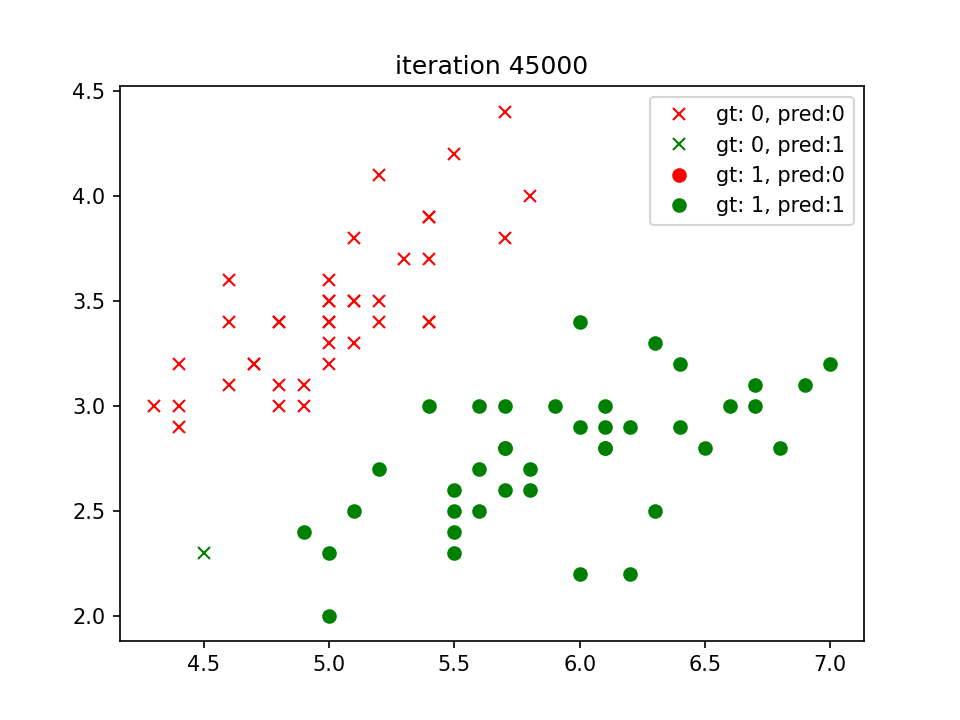

loss at iteration 46000 : -2.5998966942946717
loss at iteration 47000 : -2.5741142480198387
loss at iteration 48000 : -2.5488145324501508


<IPython.core.display.Javascript object>


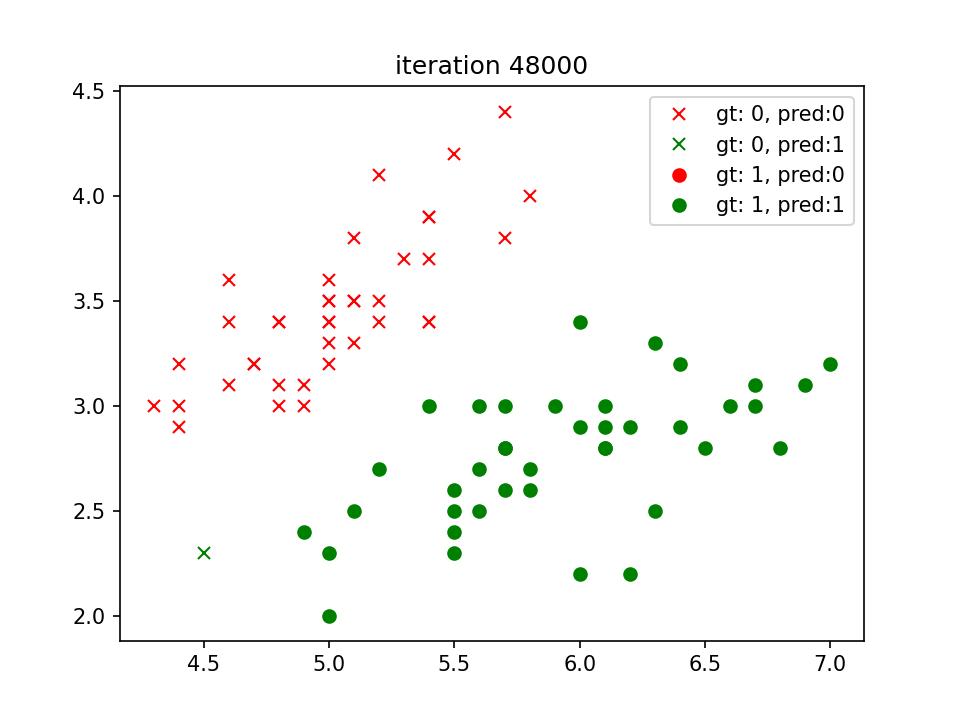

loss at iteration 49000 : -2.523986295967806
loss at iteration 50000 : -2.4996186088813652
loss at iteration 51000 : -2.475700840737357


/home/ayhon/.local/share/data/Desktop/Universidad/Tercero/1º Cuatrimestre/IML Introduction to Machine Learning/exercise4/helpers.py:183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, _ = plt.subplots(1, 1)


<IPython.core.display.Javascript object>


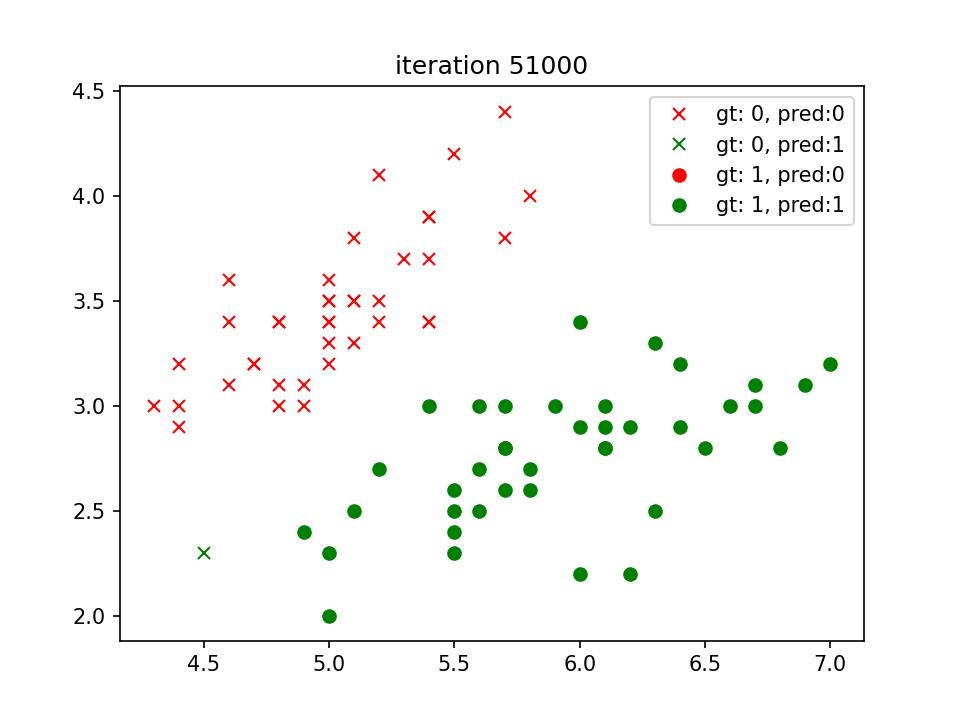

loss at iteration 52000 : -2.4522226413411503
loss at iteration 53000 : -2.4291739248358706
loss at iteration 54000 : -2.406544856297203


<IPython.core.display.Javascript object>


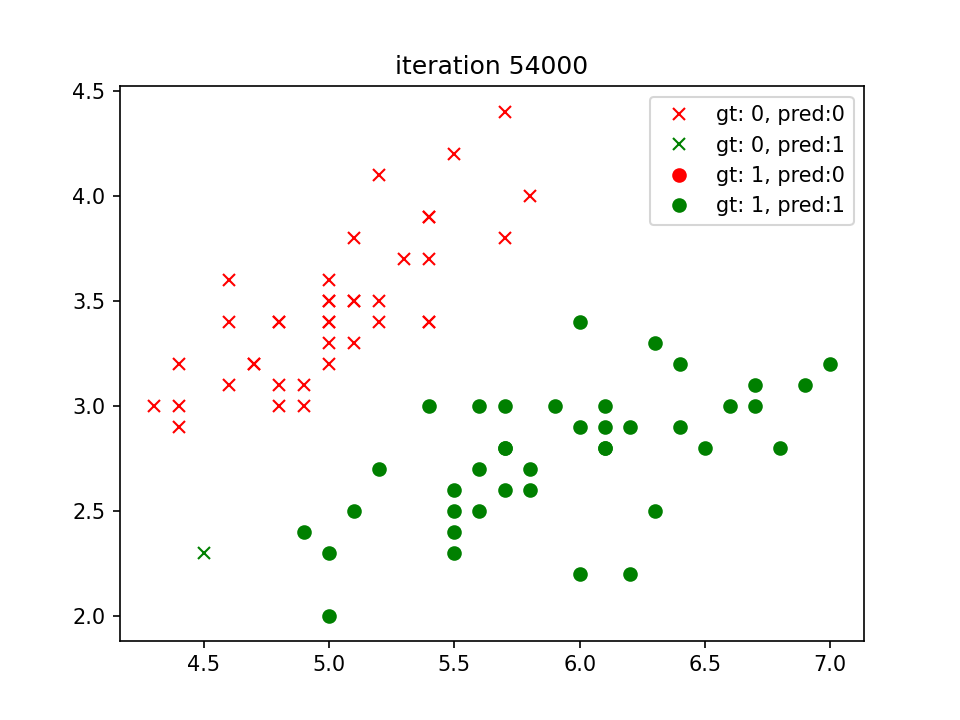

loss at iteration 55000 : -2.384325840392841
loss at iteration 56000 : -2.3625075117309704
loss at iteration 57000 : -2.3410807265856572


<IPython.core.display.Javascript object>


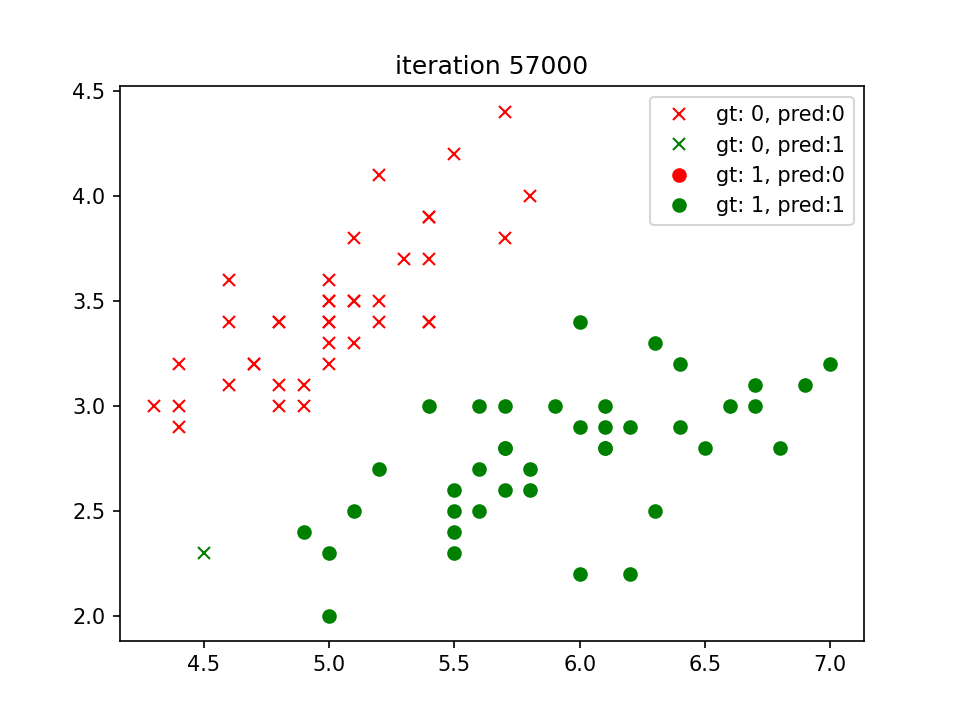

loss at iteration 58000 : -2.3200365557397813
loss at iteration 59000 : -2.2993662782307043
loss at iteration 60000 : -2.2790613758209357


<IPython.core.display.Javascript object>


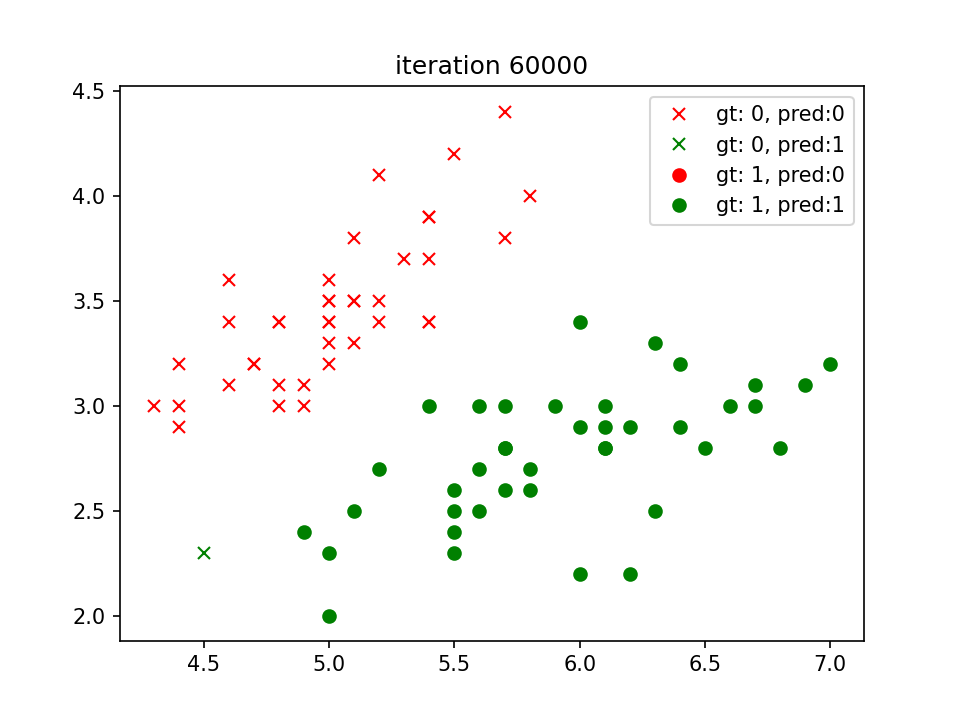

loss at iteration 61000 : -2.2591135280473322
loss at iteration 62000 : -2.2395146077283403
loss at iteration 63000 : -2.2202566768309797


<IPython.core.display.Javascript object>


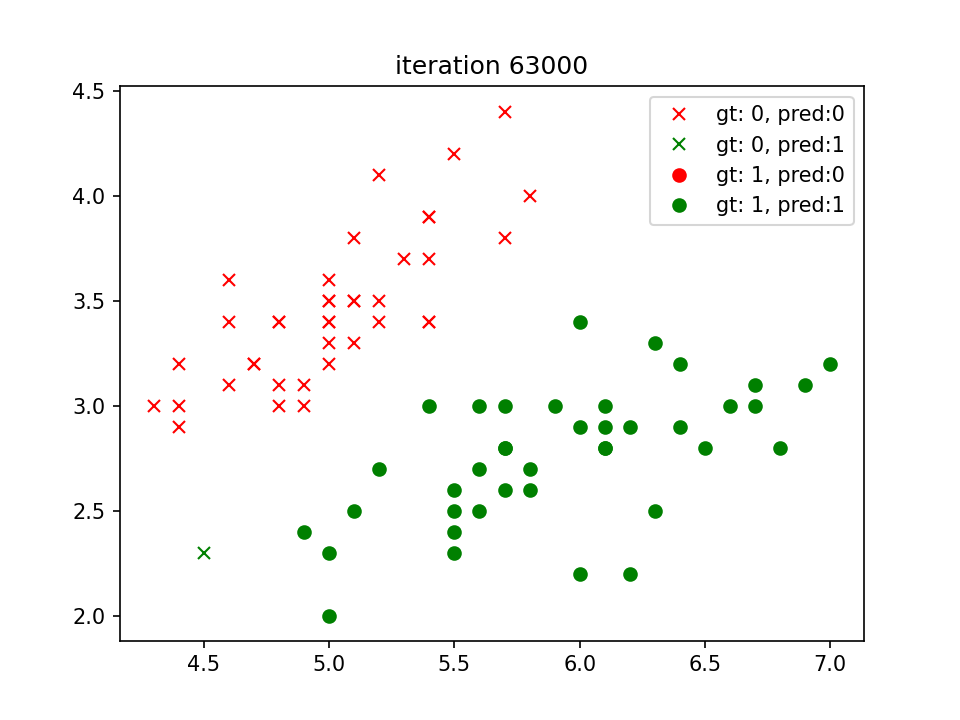

loss at iteration 64000 : -2.2013319826172717
loss at iteration 65000 : -2.1827329540053984
loss at iteration 66000 : -2.1644521980935787


<IPython.core.display.Javascript object>


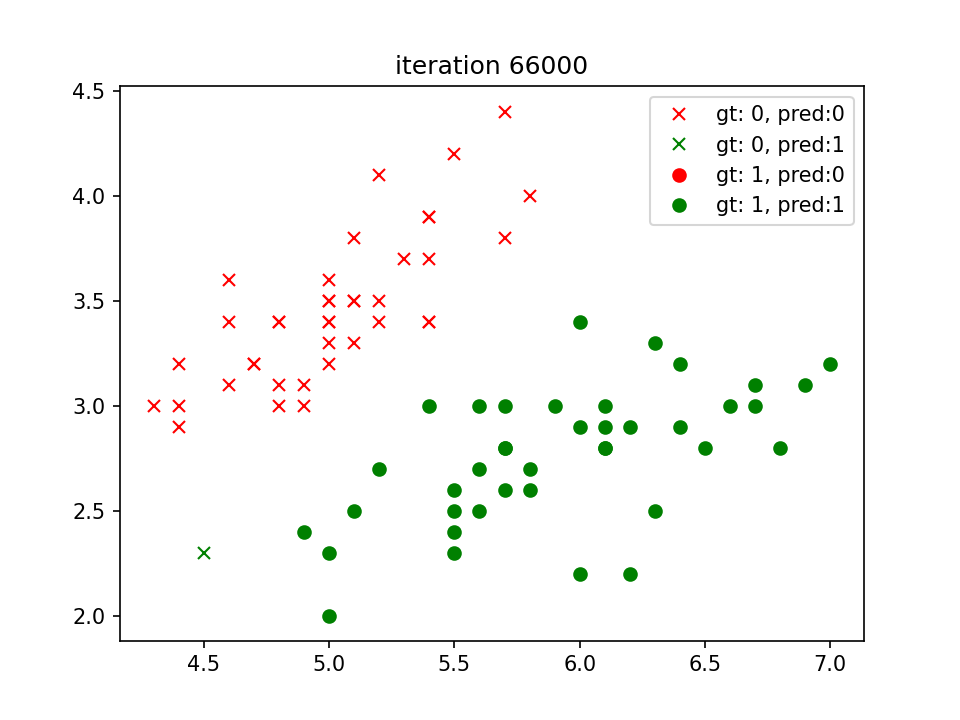

loss at iteration 67000 : -2.1464824968051697
loss at iteration 68000 : -2.128816803622696
loss at iteration 69000 : -2.1114482403853563


<IPython.core.display.Javascript object>


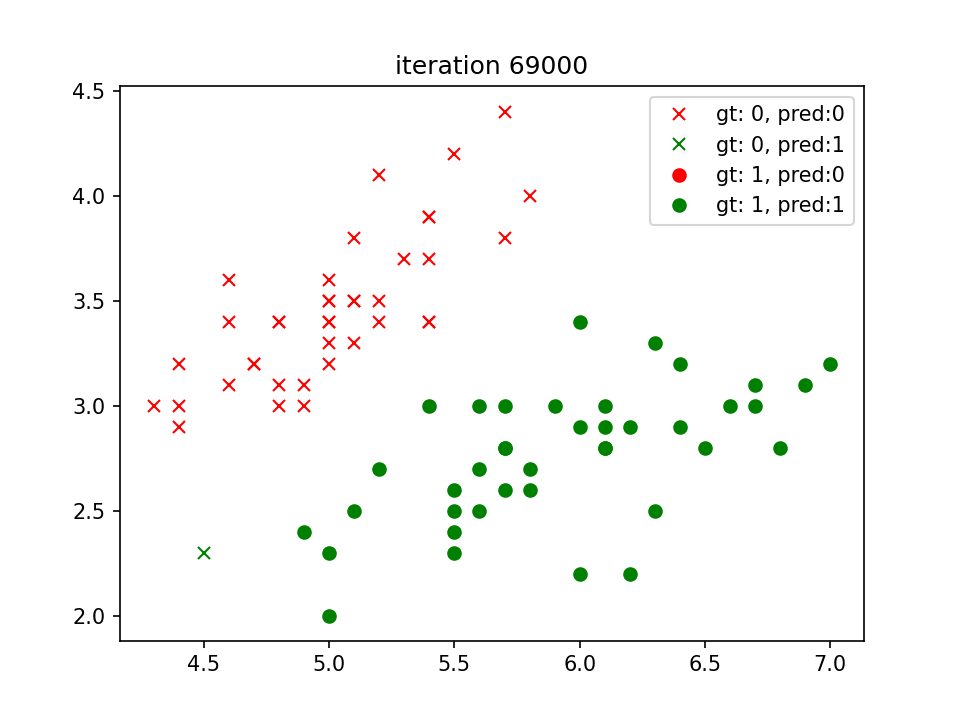

loss at iteration 70000 : -2.094370094131013
loss at iteration 71000 : -2.077575813968304
loss at iteration 72000 : -2.061059007968778


<IPython.core.display.Javascript object>


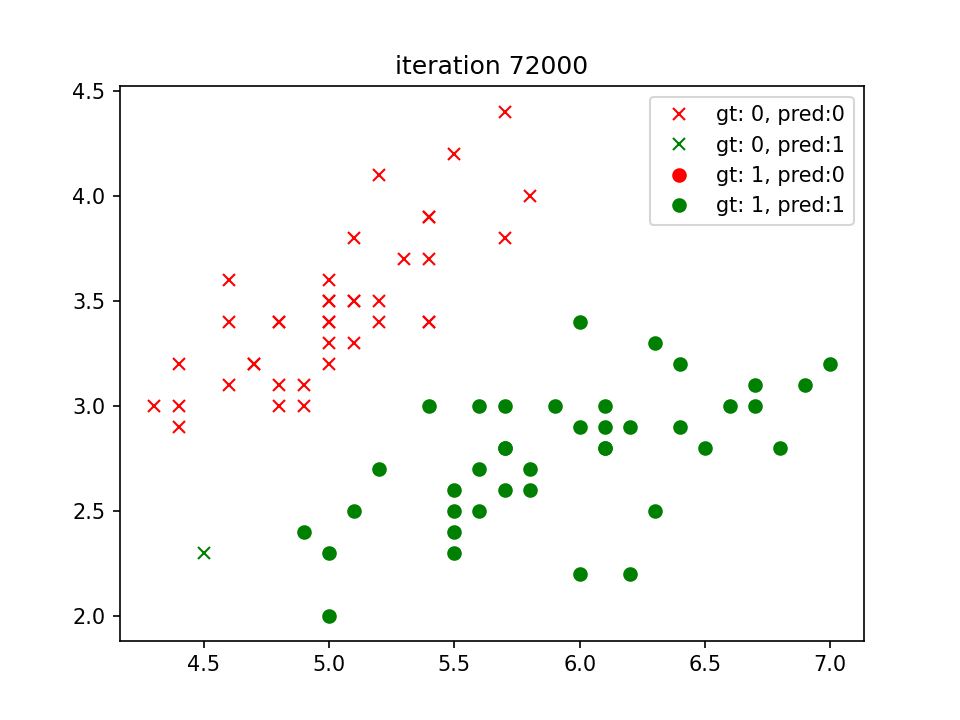

loss at iteration 73000 : -2.0448134400720215
loss at iteration 74000 : -2.0288330269994974
loss at iteration 75000 : -2.013111835174829


<IPython.core.display.Javascript object>


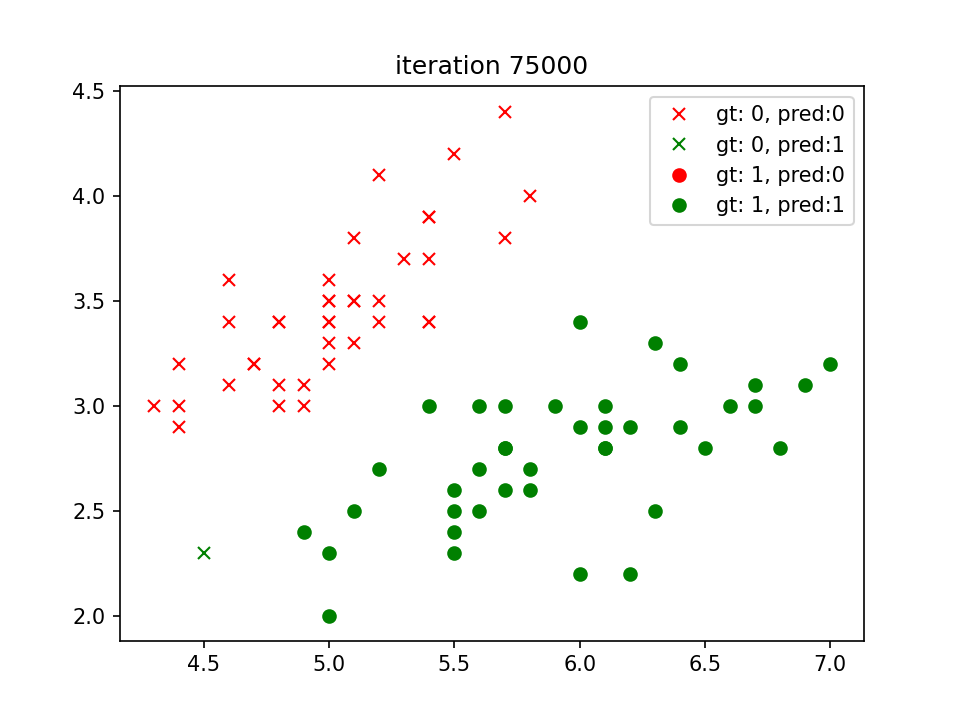

loss at iteration 76000 : -1.9976440776499156
loss at iteration 77000 : -1.9824241110375196
loss at iteration 78000 : -1.9674464324518817


<IPython.core.display.Javascript object>


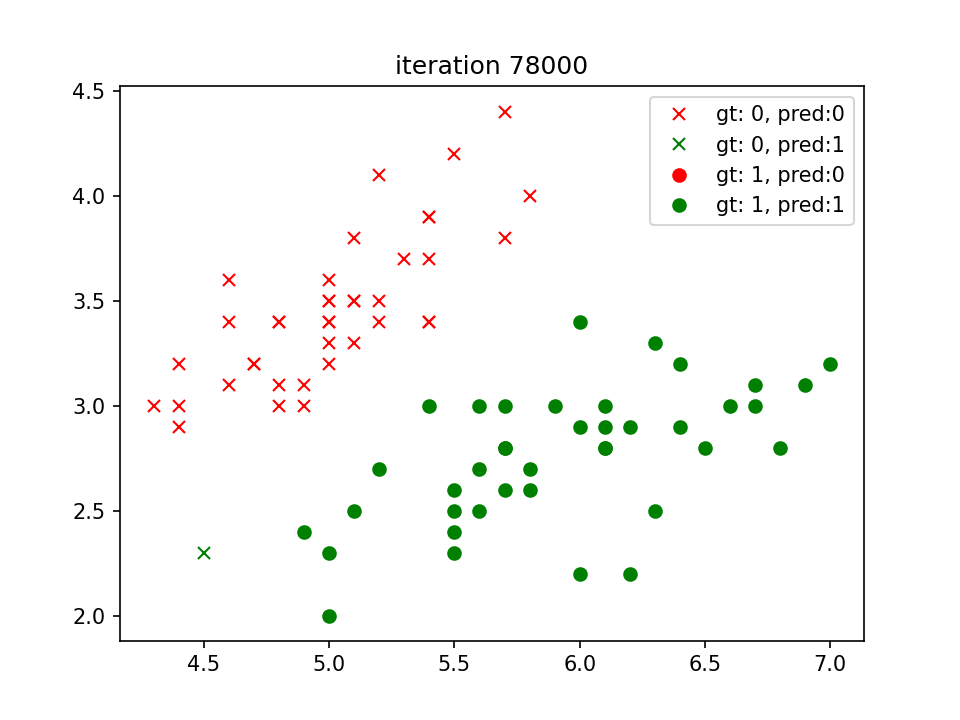

loss at iteration 79000 : -1.952705676459626
loss at iteration 80000 : -1.9381966120437593
loss at iteration 81000 : -1.9239141395837445


<IPython.core.display.Javascript object>


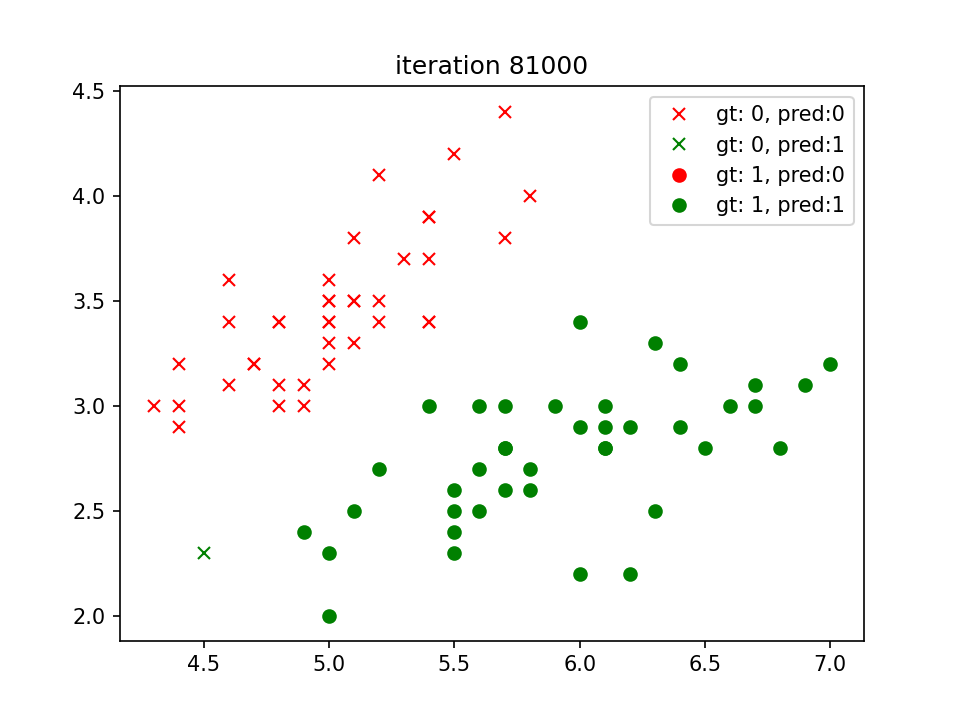

loss at iteration 82000 : -1.9098532878549346
loss at iteration 83000 : -1.8960092110506013
loss at iteration 84000 : -1.8823771858299532


<IPython.core.display.Javascript object>


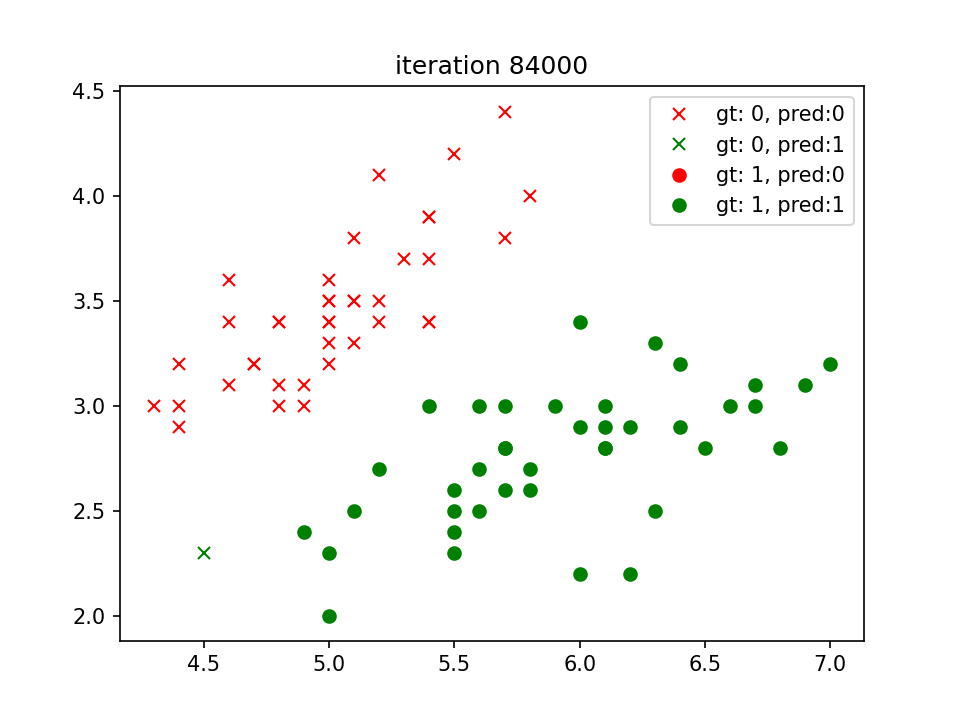

loss at iteration 85000 : -1.868952608395149
loss at iteration 86000 : -1.8557309916005256
loss at iteration 87000 : -1.8427079620967832


<IPython.core.display.Javascript object>


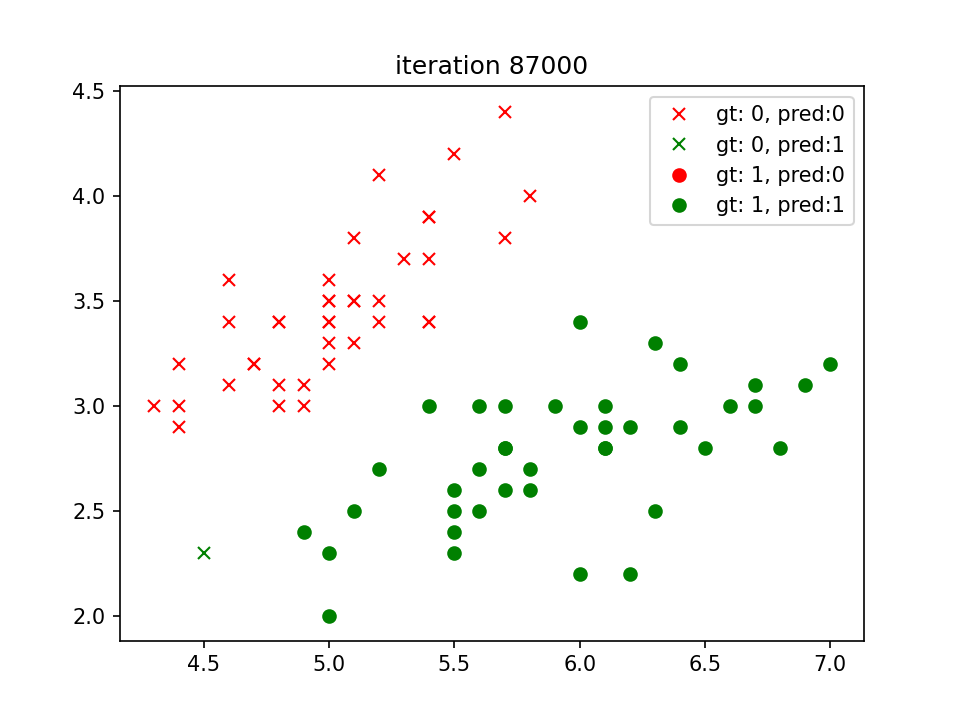

loss at iteration 88000 : -1.8298792575128615
loss at iteration 89000 : -1.8172407236779082
loss at iteration 90000 : -1.8047883118855776


<IPython.core.display.Javascript object>


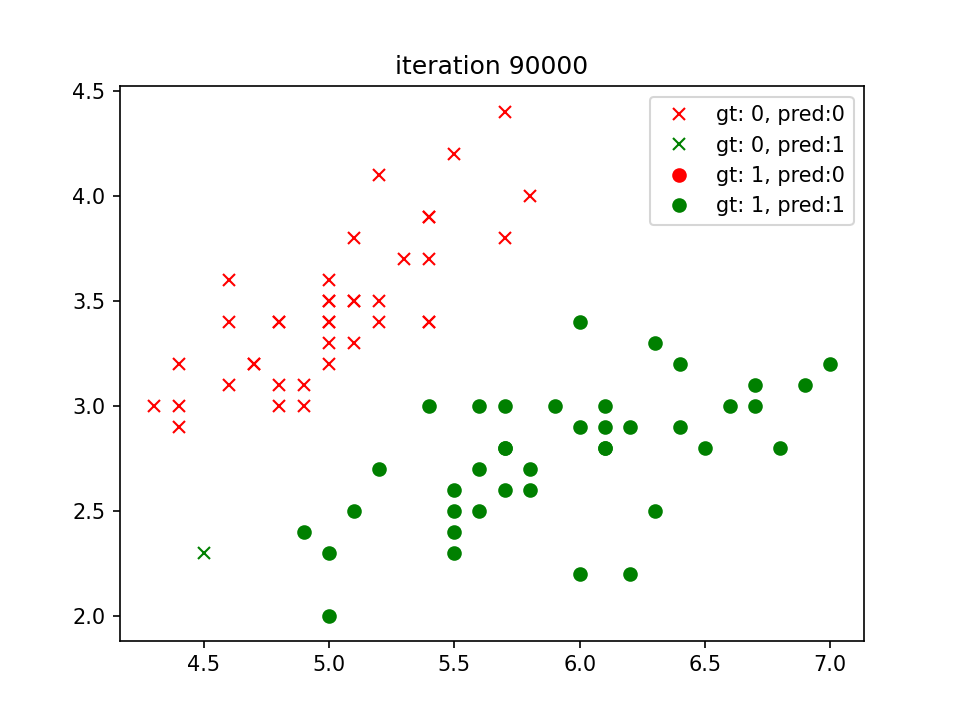

loss at iteration 91000 : -1.7925180762026325
loss at iteration 92000 : -1.7804261708235147
loss at iteration 93000 : -1.7685088474725565


<IPython.core.display.Javascript object>


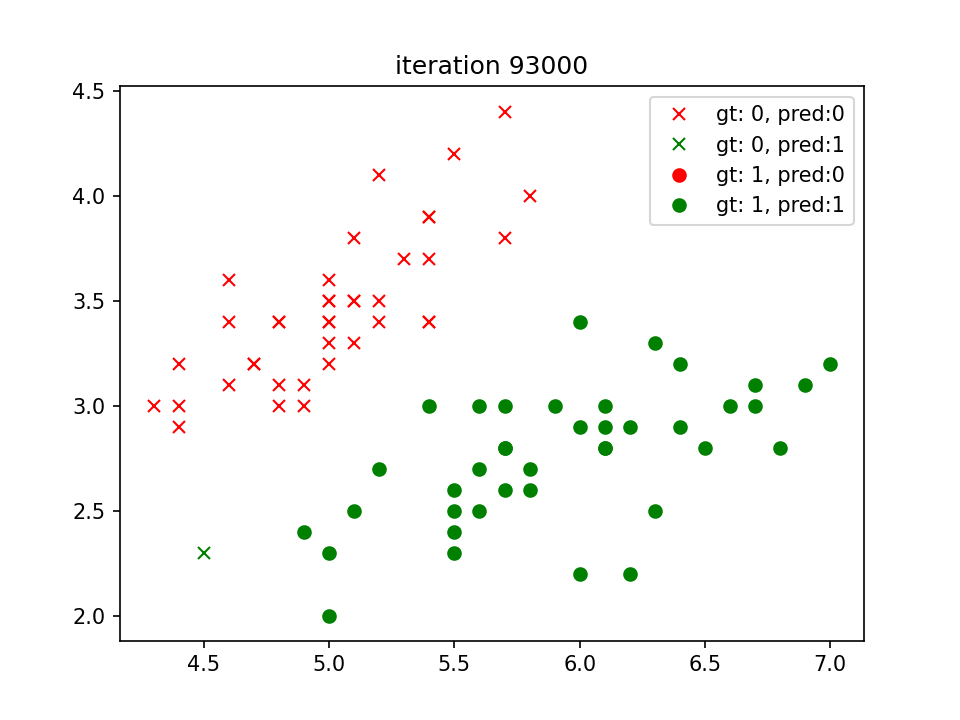

loss at iteration 94000 : -1.756762452854927
loss at iteration 95000 : -1.745183426157483
loss at iteration 96000 : -1.7337682966004015


<IPython.core.display.Javascript object>


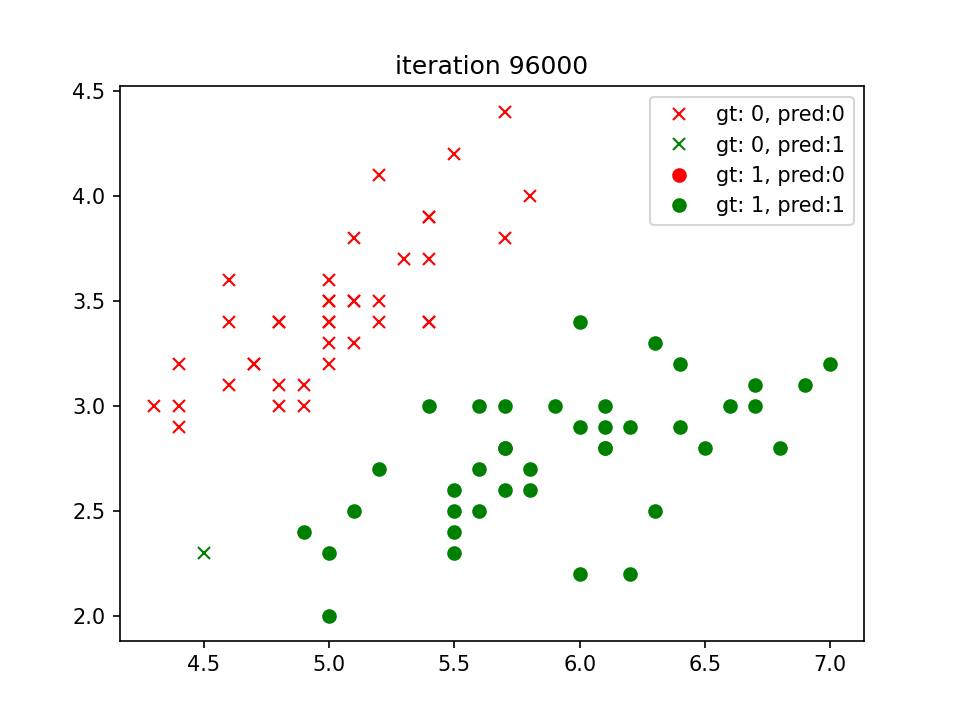

loss at iteration 97000 : -1.7225136810401769
loss at iteration 98000 : -1.7114162816245284
loss at iteration 99000 : -1.7004728834995457


<IPython.core.display.Javascript object>


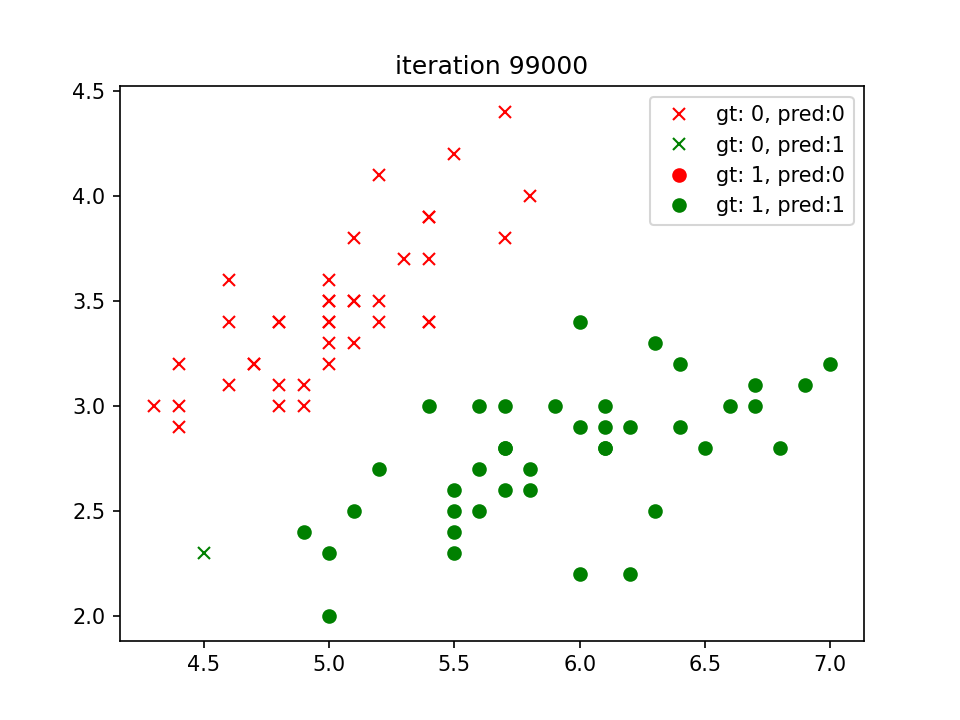

<IPython.core.display.Javascript object>


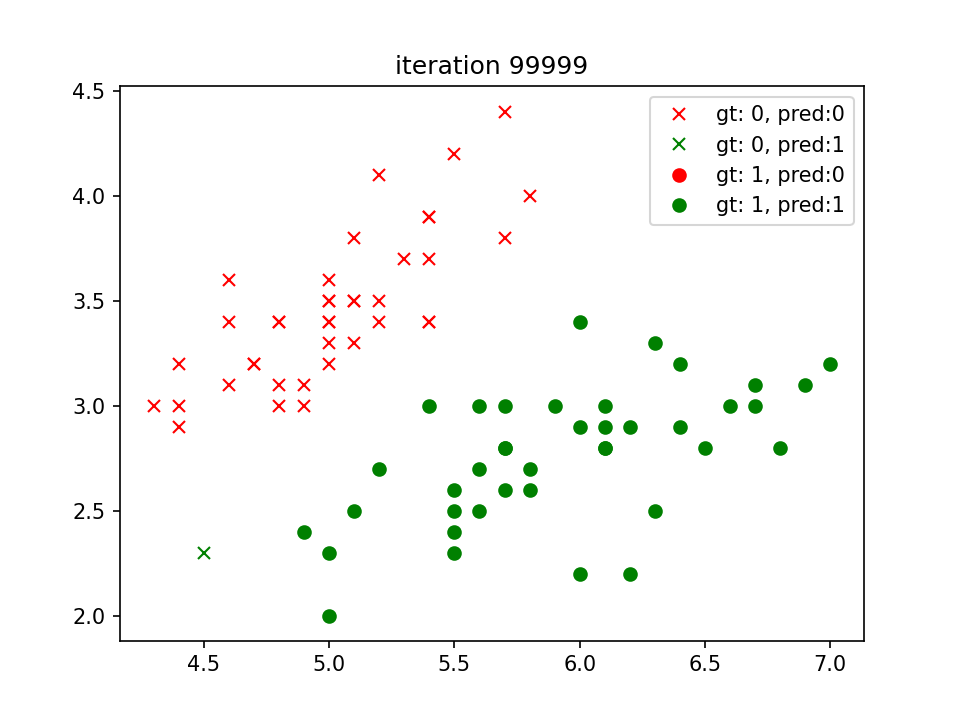

In [75]:
weights = logistic_regression_train(data_train, labels_train, max_iters=100000, lr=1e-2, print_period=1000, plot_period=3000)

<IPython.core.display.Javascript object>


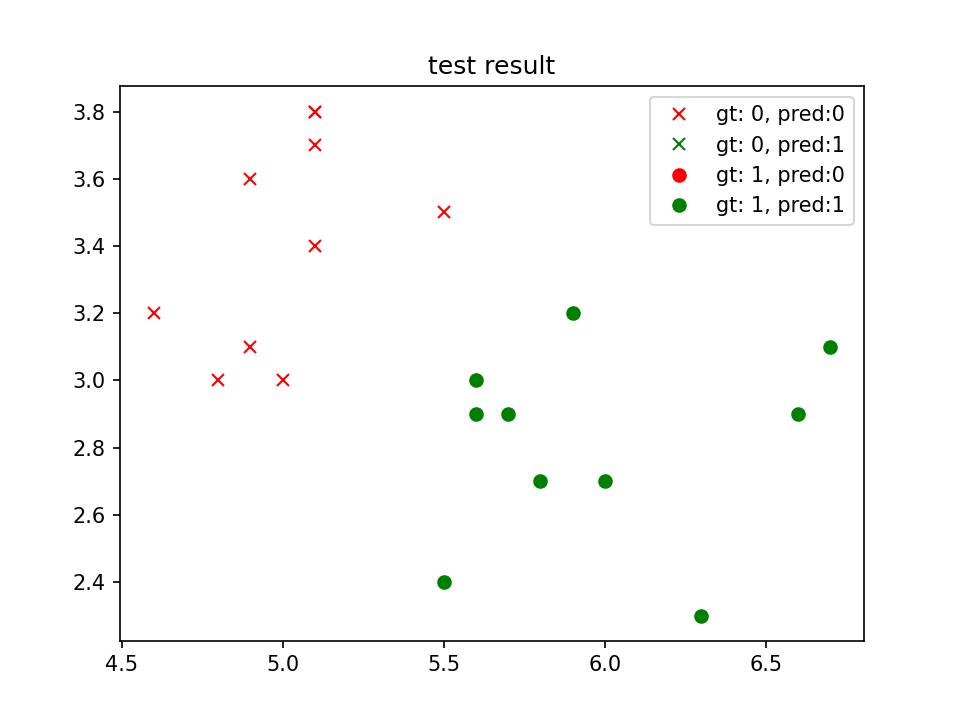

Accuracy is 1.0


In [76]:
predictions = logistic_regression_classify(data_test, weights)
fig = helpers.visualize_predictions(data=data_test, labels_gt=labels_test, labels_pred=predictions)
plt.title("test result")
print("Accuracy is", accuracy(labels_test, predictions))

# 3 Different Data

Let us now use the same dataset, with the same 2 features as before, but change the 2 classes to *versicolor* and *virginica*. As we use the features and the same number of classes, our dataset as the same form as before:

  - data: $\Xb \in \real^{N \times 3}$, $\forall \xb_i \in \Xb: \xb_i \in \real^{3}$ (2 features and the bias)
  - labels: $\yb \in \real^{N}$, $\forall y_i \in \yb: y_i \in \{0, 1\}$ 


<IPython.core.display.Javascript object>


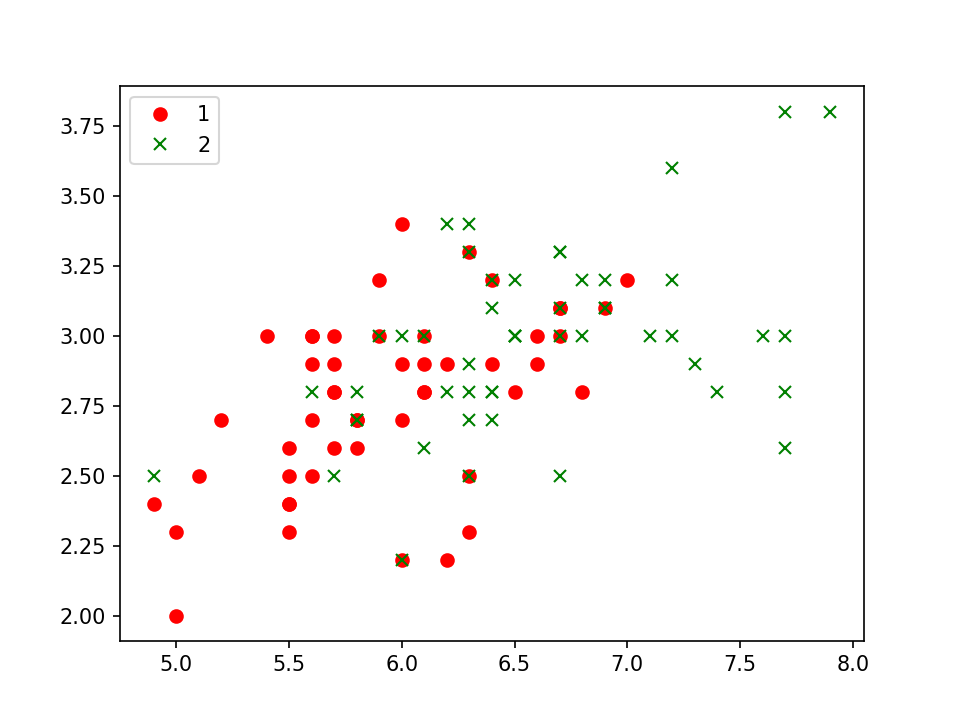

In [77]:
# Loads the data and split them into trian and test subsets.
data, labels = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False,
                              setosa=False, versicolor=True, virginica=True, addbias=True)
fig = helpers.scatter2d_multiclass(data, labels)

num_samples = data.shape[0]

fraction_train = 0.8
np.random.seed(0)
rinds = np.random.permutation(num_samples)

data_train = data[rinds[:int(num_samples * fraction_train)]] 
labels_train = labels[rinds[:int(num_samples * fraction_train)]]  
labels_train[labels_train==2] = 0

data_test = data[rinds[int(num_samples * fraction_train):]] 
labels_test = labels[rinds[int(num_samples * fraction_train):]]  
labels_test[labels_test==2] = 0




Now you can perform training and evaluation on this dataset. We leave this part to you. 
Note: We recommend reducing the plotting period of the `logistic_regression_train` function.

In [85]:
print(labels_test.shape)
print(data_test.shape)
print()
print(labels_train.shape)
print(data_train.shape)

(20,)
(20, 3)

(80,)
(80, 3)


loss at iteration 0 : -55.38880588517779


<IPython.core.display.Javascript object>


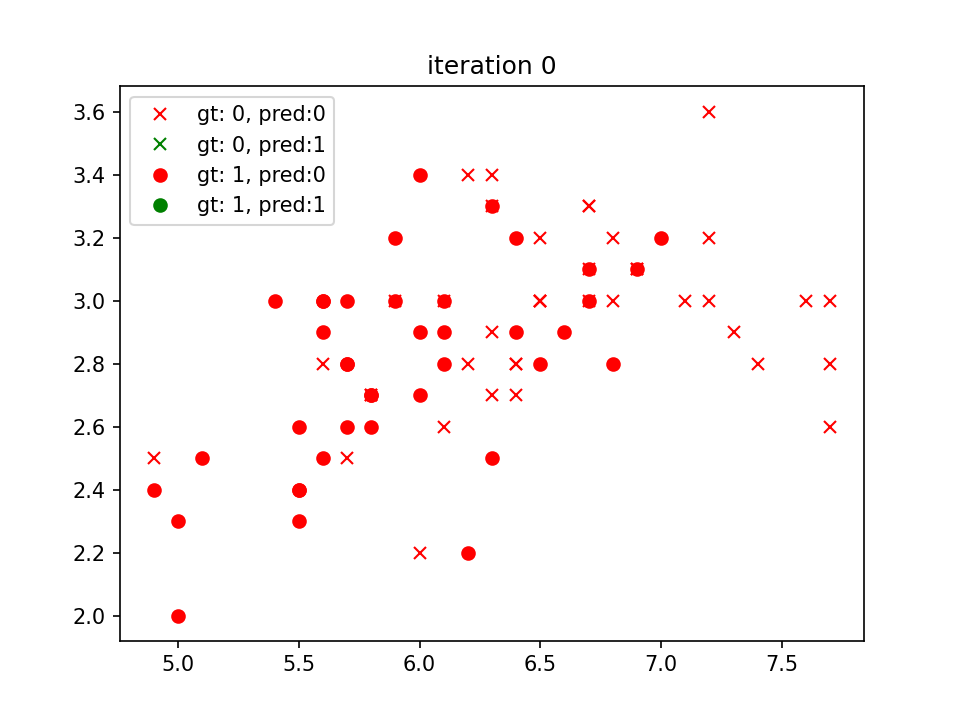

<IPython.core.display.Javascript object>


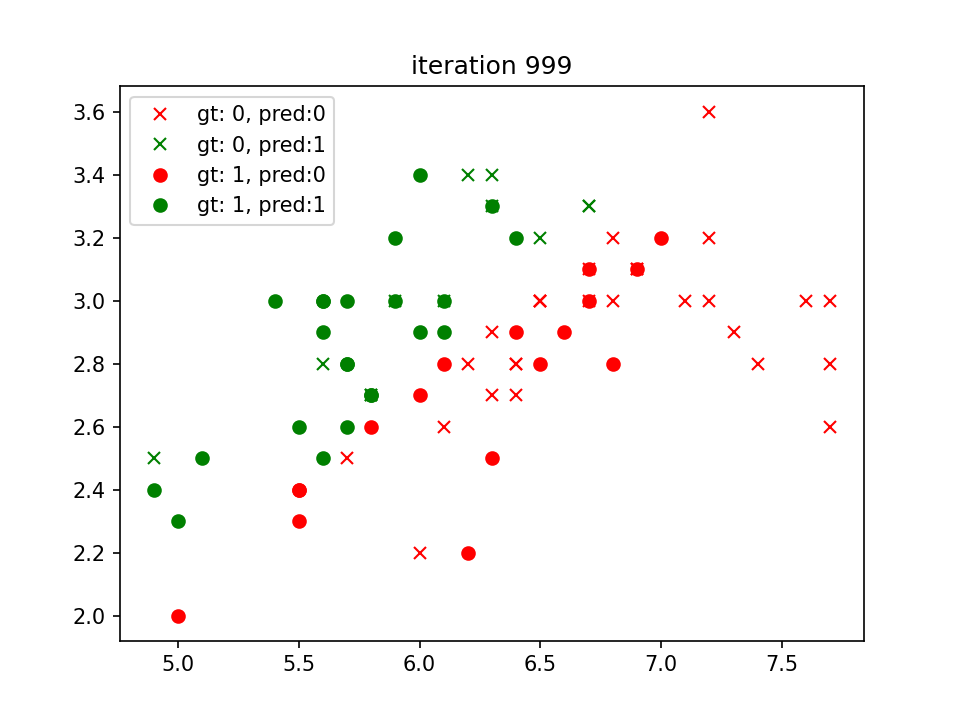

(20,)


<IPython.core.display.Javascript object>


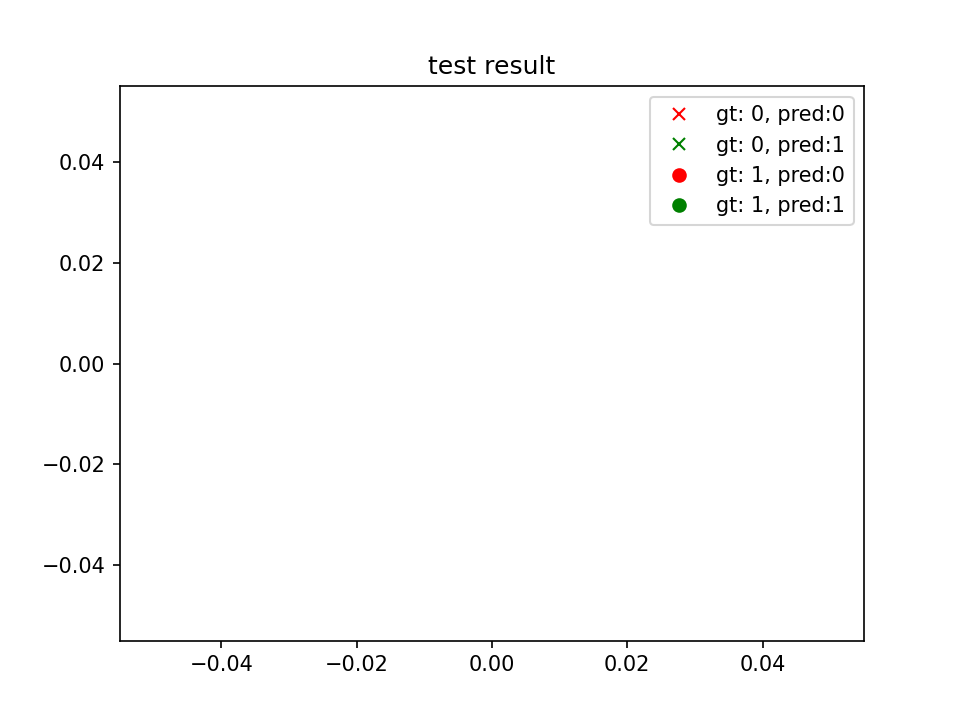

Test Accuracy is 0.0


In [86]:
#Train
weights = logistic_regression_train(data_train, labels_train, max_iters=1000, lr=0.001,print_period=1000, plot_period=1000)
#Predict
predictions = sigmoid(data_test @ weights)
print(predictions.shape)

fig = helpers.visualize_predictions(data=data_test, labels_gt=labels_test, labels_pred=predictions)
plt.title("test result")

#Calculate accuracy
test_accuracy = accuracy(labels_test, predictions)
print("Test Accuracy is", test_accuracy)

**Q: Comment on the accuracy. What is the difference between the dataset  in the first part and this one?**
 

In this dataset, the values were mixed togh